In [28]:
import cv2
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
import os
import glob
from torchvision import transforms
from PIL import Image

# Define folders (each folder represents a class)
folders = {
    "kaggle_train/imagenet/n01768244": 1,  # Class label 1
    "kaggle_train/imagenet/n01770393": 2,  # Class label 2
    "kaggle_train/imagenet/n01774384": 3,  # Class label 2
    "kaggle_train/imagenet/n02058221": 4,  # Class label 2
    "kaggle_train/imagenet/n02074367": 5,  # Class label 2
    "kaggle_train/imagenet/n02099601": 6,  # Class label 2
    "kaggle_train/imagenet/n02106662": 7,  # Class label 2
    "kaggle_train/imagenet/n02132136": 8,  # Class label 2
    "kaggle_train/imagenet/n02410509": 9,  # Class label 2
    "kaggle_train/imagenet/n02481823": 10,  # Class label 1
    "kaggle_train/imagenet/n02486410": 11,  # Class label 2
    "kaggle_train/imagenet/n02504458": 12,  # Class label 2
    "kaggle_train/imagenet/n02666196": 13,  # Class label 2
    "kaggle_train/imagenet/n02730930": 14,  # Class label 2
    "kaggle_train/imagenet/n02814533": 15,  # Class label 2
    "kaggle_train/imagenet/n03444034": 16,  # Class label 2
    "kaggle_train/imagenet/n03447447": 17,  # Class label 2
    "kaggle_train/imagenet/n03649909": 18,  # Class label 2
    "kaggle_train/imagenet/n03930313": 19,  # Class label 1
    "kaggle_train/imagenet/n04067472": 20,  # Class label 2
    "kaggle_train/imagenet/n04118538": 21,  # Class label 2
    "kaggle_train/imagenet/n04265275": 22,  # Class label 2
    "kaggle_train/imagenet/n04311004": 23,  # Class label 2
    "kaggle_train/imagenet/n04456115": 24,  # Class label 2
    "kaggle_train/imagenet/n04487081": 25,  # Class label 2
    "kaggle_train/imagenet/n04562935": 26,  # Class label 2
    "kaggle_train/imagenet/n07753592": 27,  # Class label 2
    "kaggle_train/imagenet/n07768694": 28,  # Class label 2
    "kaggle_train/imagenet/n07873807": 29,  # Class label 2
    "kaggle_train/imagenet/n09332890": 30,  # Class label 2
    
}

# Parameters
img_size = (256, 256)  # Resize images
sift_features_dim = 512
hog_features_dim = 512
color_hist_dim = 128

# Alterable
lbp_radius = 1
lbp_points = 8 * lbp_radius

resnet_dim = 2048  # ResNet-50 feature size

# Initialize feature extractors
sift = cv2.SIFT_create(nfeatures=sift_features_dim)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last layer
resnet.eval()  # Set to evaluation mode

# Define preprocessing for ResNet-50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Lists to store features and labels
X_sift, X_hog, X_color_hist, X_canny, X_lbp, X_resnet, y = [], [], [], [], [], [], []

# Process images
for folder, label in folders.items():
    image_paths = glob.glob(os.path.join(folder, "*.jpeg")) + \
              glob.glob(os.path.join(folder, "*.JPEG"))
    for img_path in image_paths:
        # Read image
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img, img_size)
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # **1. SIFT (512D)**
        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        if descriptors is None:
            descriptors = np.zeros((sift_features_dim, 128))
        else:
            descriptors = descriptors[:sift_features_dim]
        sift_feature_vector = descriptors.flatten()
        sift_feature_vector = np.pad(sift_feature_vector, (0, sift_features_dim * 128 - len(sift_feature_vector)), mode='constant')

        # **2. HOG (256D-512D)**
        hog_feature_vector = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, feature_vector=True)
        hog_feature_vector = np.pad(hog_feature_vector, (0, hog_features_dim - len(hog_feature_vector)), mode='constant')

        # **3. Color Histogram (64D-128D)**
        hist_b = cv2.calcHist([img], [0], None, [color_hist_dim//3], [0, 256]).flatten()
        hist_g = cv2.calcHist([img], [1], None, [color_hist_dim//3], [0, 256]).flatten()
        hist_r = cv2.calcHist([img], [2], None, [color_hist_dim//3], [0, 256]).flatten()
        color_hist_vector = np.concatenate((hist_b, hist_g, hist_r)).flatten()
        color_hist_vector = color_hist_vector / np.sum(color_hist_vector)  # Normalize

        # **4. Canny Edge Detection**
        canny_edges = cv2.Canny(img_gray, 100, 200).flatten()
        canny_edges = np.pad(canny_edges, (0, img_size[0] * img_size[1] - len(canny_edges)), mode='constant')

        # **5. Local Binary Patterns (LBP)**
        lbp = local_binary_pattern(img_gray, lbp_points, lbp_radius, method="uniform").flatten()
        lbp = np.pad(lbp, (0, img_size[0] * img_size[1] - len(lbp)), mode='constant')

        # **6. ResNet-50 (2048D)**
        img_tensor = transform(img_pil).unsqueeze(0)  # Convert to tensor
        with torch.no_grad():
            resnet_features = resnet(img_tensor).squeeze().cpu().numpy()
        
        # Store features
        X_sift.append(sift_feature_vector)
        X_hog.append(hog_feature_vector)
        X_color_hist.append(color_hist_vector)
        X_canny.append(canny_edges)
        X_lbp.append(lbp)
        X_resnet.append(resnet_features)
        y.append(label)



c:\Users\adity\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adity\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import pandas as pd

# 1. Read in your three files
df1 = pd.read_csv('laion_bigG_pca_50_relabelled.csv')   # columns: ID, CLUSTER
df2 = pd.read_csv('opena_large_patch_336_relabelled.csv')
df3 = pd.read_csv('dino_large_relabelled.csv')

# 2. Merge them on ID, giving each CLUSTER column a unique name
df = (
    df1
    .merge(df2, on='ID', suffixes=('_1', '_2'))
    .merge(df3.rename(columns={'CLUSTER':'CLUSTER_3'}), on='ID')
)

# 3. Define the “ensemble” rule
def ensemble_vote(c1, c2, c3):
    # if any two agree, return that cluster
    if c1 == c2 or c1 == c3:
        return c1
    if c2 == c3:
        return c2
    # otherwise (all three different) default to file1’s choice
    return c1

# 4. Apply it row‐wise
df['CLUSTER'] = df.apply(
    lambda r: ensemble_vote(r['CLUSTER_1'], r['CLUSTER_2'], r['CLUSTER_3']),
    axis=1
)

# 5. Keep only ID and the new CLUSTER column
out = df[['ID', 'CLUSTER']]

# 6. Write out
out.to_csv('ensembled_clusters.csv', index=False)


In [36]:
# Reduce dataset to 1/5th of its original size
subset_indices = np.random.choice(len(y), len(y) // 5, replace=False)

X_sift_ = np.array([X_sift[i] for i in subset_indices], dtype=np.float16)
X_hog_ = np.array([X_hog[i] for i in subset_indices], dtype=np.float16)
X_color_hist_ = np.array([X_color_hist[i] for i in subset_indices], dtype=np.float16)
X_canny_ = np.array([X_canny[i] for i in subset_indices], dtype=np.float16)
X_lbp_ = np.array([X_lbp[i] for i in subset_indices], dtype=np.float16)
X_resnet_ = np.array([X_resnet[i] for i in subset_indices], dtype=np.float16)
y_ = np.array([y[i] for i in subset_indices]) 


# Split into Train (60%), Validation (20%), Test (20%)
X_sift_train, X_sift_temp, y_train, y_temp = train_test_split(X_sift_, y_, test_size=0.4, stratify=y_, random_state=782)
X_sift_val, X_sift_test, y_val, y_test = train_test_split(X_sift_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=782)

X_hog_train, X_hog_temp, _, _ = train_test_split(X_hog_, y_, test_size=0.4, stratify=y_, random_state=782)
X_hog_val, X_hog_test, _, _ = train_test_split(X_hog_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=782)

X_color_hist_train, X_color_hist_temp, _, _ = train_test_split(X_color_hist_, y_, test_size=0.4, stratify=y_, random_state=782)
X_color_hist_val, X_color_hist_test, _, _ = train_test_split(X_color_hist_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=782)

X_canny_train, X_canny_temp, _, _ = train_test_split(X_canny_, y_, test_size=0.4, stratify=y_, random_state=782)
X_canny_val, X_canny_test, _, _ = train_test_split(X_canny_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=782)

X_lbp_train, X_lbp_temp, _, _ = train_test_split(X_lbp_, y_, test_size=0.4, stratify=y_, random_state=782)
X_lbp_val, X_lbp_test, _, _ = train_test_split(X_lbp_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=782)

X_resnet_train, X_resnet_temp, _, _ = train_test_split(X_resnet_, y_, test_size=0.4, stratify=y_, random_state=782)
X_resnet_val, X_resnet_test, _, _ = train_test_split(X_resnet_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=782)

# Print dataset sizes
print(f"SIFT Train: {X_sift_train.shape}, Val: {X_sift_val.shape}, Test: {X_sift_test.shape}")
print(f"HOG Train: {X_hog_train.shape}, Val: {X_hog_val.shape}, Test: {X_hog_test.shape}")
print(f"Color Hist Train: {X_color_hist_train.shape}, Val: {X_color_hist_val.shape}, Test: {X_color_hist_test.shape}")
print(f"Canny Train: {X_canny_train.shape}, Val: {X_canny_val.shape}, Test: {X_canny_test.shape}")
print(f"LBP Train: {X_lbp_train.shape}, Val: {X_lbp_val.shape}, Test: {X_lbp_test.shape}")
print(f"ResNet Train: {X_resnet_train.shape}, Val: {X_resnet_val.shape}, Test: {X_resnet_test.shape}")

SIFT Train: (3600, 65536), Val: (1200, 65536), Test: (1200, 65536)
HOG Train: (3600, 512), Val: (1200, 512), Test: (1200, 512)
Color Hist Train: (3600, 126), Val: (1200, 126), Test: (1200, 126)
Canny Train: (3600, 65536), Val: (1200, 65536), Test: (1200, 65536)
LBP Train: (3600, 65536), Val: (1200, 65536), Test: (1200, 65536)
ResNet Train: (3600, 2048), Val: (1200, 2048), Test: (1200, 2048)


In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances

    # dimension reduction
    # train test val
    # hyperparameter
    # deleting useless memory
# Function to combine all classical features
def combine_classical_features(X_sift, X_hog, X_color_hist, X_canny, X_lbp):
    return np.hstack([X_sift, X_hog, X_color_hist, X_canny, X_lbp])

# For each split, combine the classical features:
X_classical_train = combine_classical_features(X_sift_train, X_hog_train, X_color_hist_train, X_canny_train, X_lbp_train)
X_classical_val   = combine_classical_features(X_sift_val,   X_hog_val,   X_color_hist_val,   X_canny_val,   X_lbp_val)
X_classical_test  = combine_classical_features(X_sift_test,  X_hog_test,  X_color_hist_test,  X_canny_test,  X_lbp_test)

# Combine classical features with ResNet features for each split:
X_combined_train = np.hstack([X_classical_train, X_resnet_train])
X_combined_val   = np.hstack([X_classical_val,   X_resnet_val])
X_combined_test  = np.hstack([X_classical_test,  X_resnet_test])


# ----- t-SNE Visualization -----
def plot_tsne(features, cluster_labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=782)
    tsne_results = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                          c=cluster_labels, cmap="viridis", alpha=0.7)
    plt.title(title)
    plt.colorbar(scatter)
    plt.show()


In [47]:
# del X_sift_train, X_hog_train, X_color_hist_train, X_canny_train, X_lbp_train, X_sift_val,X_hog_val,X_color_hist_val, X_canny_val, X_lbp_val, X_sift_test,  X_hog_test,  X_color_hist_test,  X_canny_test,  X_lbp_test

def transform_for_metric(X, metric):
    """
    Returns a version of X suitable for the chosen distance metric:
      - 'l2': no change (already suitable for Euclidean)
      - 'cosine': row-normalize each sample to unit length
      - 'l1': no special transform here; K-Medians will handle L1 internally
    """
    if metric == "l2":
        return X  # No change needed
    elif metric == "cosine":
        # Normalize each row to unit length -> Euclidean ~ Cosine
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        # To avoid division by zero for zero-vectors
        norms[norms == 0] = 1e-9
        return X / norms
    elif metric == "l1":
        # For K-Medians, no special transform required
        return X
    else:
        raise ValueError(f"Unknown metric: {metric}")


Variant=kmeans, metric=l2, batch_size=None, val ARI=0.0115


c:\Users\adity\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Variant=minibatchkmeans, metric=l2, batch_size=50, val ARI=0.0097


c:\Users\adity\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Variant=minibatchkmeans, metric=l2, batch_size=100, val ARI=-0.0000


c:\Users\adity\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Variant=minibatchkmeans, metric=l2, batch_size=200, val ARI=0.0016

Best Params on VAL -> Variant=kmeans, metric=l2, batch_size=None with ARI=0.0115

[Final] Test ARI = 0.0127 (Variant=kmeans, Metric=l2, BatchSize=None)


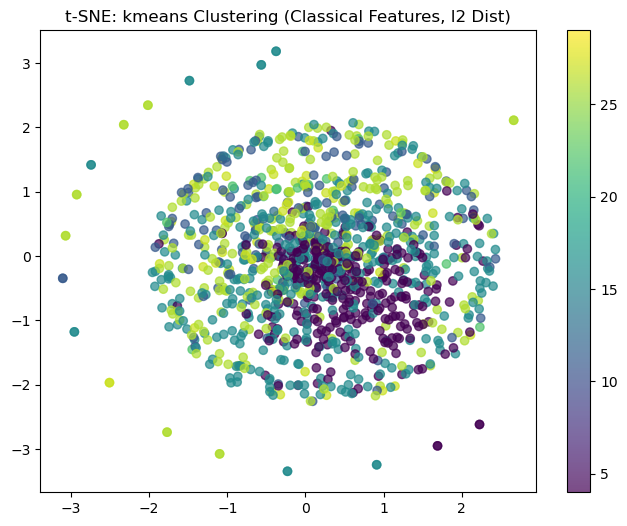

In [50]:
# KMeans classical
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
# from sklearn_extra.cluster import KMedians
from sklearn.metrics import adjusted_rand_score


scaler_classical = StandardScaler()
X_classical_train_scaled = scaler_classical.fit_transform(X_classical_train)
X_classical_val_scaled   = scaler_classical.transform(X_classical_val)
X_classical_test_scaled  = scaler_classical.transform(X_classical_test)

n_clusters = 30  
batch_size_candidates = [50, 100, 200]  # Example hyperparameter search space

search_variants = ["kmeans", "minibatchkmeans"]
search_metrics = ["l2", "l1"]

best_ari = -1.0
best_params = (None, None, None)  # (variant, metric, batch_size)

for variant in search_variants:
    for metric in search_metrics:
        # Skip invalid combos
        if variant in ["kmeans", "minibatchkmeans"] and metric == "l1":
            continue  # scikit-learn KMeans doesn't do L1
        if variant == "kmedians" and metric != "l1":
            continue  # K-Medians typically used with L1

        # Transform train/val data for chosen metric
        X_train_metric = transform_for_metric(X_classical_train_scaled, metric)
        X_val_metric = transform_for_metric(X_classical_val_scaled, metric)

        # Prepare list of batch sizes (only relevant if variant == 'minibatchkmeans')
        if variant == "minibatchkmeans":
            possible_batch_sizes = batch_size_candidates
        else:
            possible_batch_sizes = [None]  # We'll pass no batch_size for KMeans / KMedians

        for b_size in possible_batch_sizes:
            # 1) Initialize the clustering model
            if variant == "kmeans":
                model = KMeans(n_clusters=n_clusters, random_state=782, n_init=10)
            elif variant == "minibatchkmeans":
                model = MiniBatchKMeans(n_clusters=n_clusters, random_state=782,
                                        n_init=10, batch_size=b_size)
            # elif variant == "kmedians":
            #     # By default, K-Medians uses L1 distance
            #     model = KMedians(n_clusters=n_clusters, random_state=782)
            else:
                raise ValueError(f"Unknown variant: {variant}")

            # 2) Fit on TRAIN
            model.fit(X_train_metric)

            # 3) Predict on VAL
            val_preds = model.predict(X_val_metric)

            # 4) Compute ARI
            val_ari = adjusted_rand_score(y_val, val_preds)

            print(f"Variant={variant}, metric={metric}, batch_size={b_size}, val ARI={val_ari:.4f}")

            # Track the best
            if val_ari > best_ari:
                best_ari = val_ari
                best_params = (variant, metric, b_size)

print(f"\nBest Params on VAL -> Variant={best_params[0]}, metric={best_params[1]}, batch_size={best_params[2]} with ARI={best_ari:.4f}")

# Extract best hyperparameters
best_variant, best_metric, best_batch_size = best_params

# 1) Combine Train+Val
X_train_val = np.vstack([X_classical_train_scaled, X_classical_val_scaled])
y_train_val = np.hstack([y_train, y_val])

# 2) Transform for best metric
X_train_val_metric = transform_for_metric(X_train_val, best_metric)
X_test_metric = transform_for_metric(X_classical_test_scaled, best_metric)

# 3) Initialize final model
if best_variant == "kmeans":
    final_model = KMeans(n_clusters=n_clusters, random_state=782, n_init=10)
elif best_variant == "minibatchkmeans":
    final_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=782, n_init=10,
                                  batch_size=best_batch_size)
# elif best_variant == "kmedians":
    # final_model = KMedians(n_clusters=n_clusters, random_state=782)
else:
    raise ValueError(f"Unknown best variant: {best_variant}")

# 4) Fit on (Train+Val)
final_model.fit(X_train_val_metric)

# 5) Predict on Test
test_preds = final_model.predict(X_test_metric)

# 6) Compute ARI on Test
test_ari = adjusted_rand_score(y_test, test_preds)
print(f"\n[Final] Test ARI = {test_ari:.4f} (Variant={best_variant}, Metric={best_metric}, BatchSize={best_batch_size})")

# 7) Optional t-SNE Visualization
plot_tsne(X_test_metric, test_preds, f"t-SNE: {best_variant} Clustering (Classical Features, {best_metric} Dist)")


Variant=kmeans, metric=l2, batch_size=None, val ARI=0.0166


c:\Users\adity\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Variant=minibatchkmeans, metric=l2, batch_size=50, val ARI=0.0037


c:\Users\adity\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Variant=minibatchkmeans, metric=l2, batch_size=100, val ARI=0.0114


c:\Users\adity\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Variant=minibatchkmeans, metric=l2, batch_size=200, val ARI=0.0000

Best Params on VAL -> Variant=kmeans, metric=l2, batch_size=None with ARI=0.0166

[Final] Test ARI = 0.0191 (Variant=kmeans, Metric=l2, BatchSize=None)


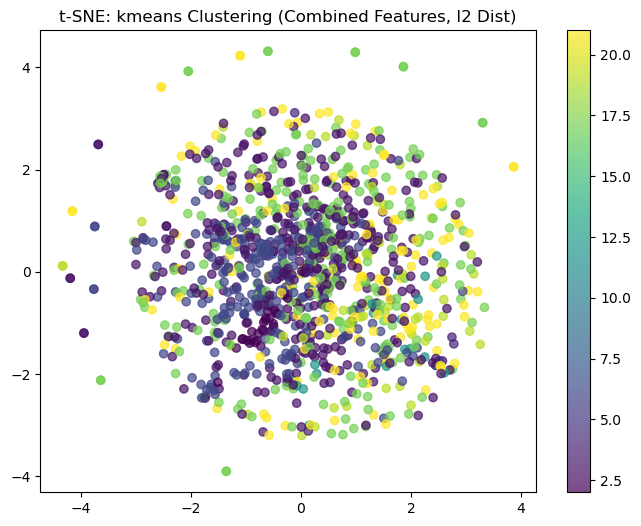

In [51]:
# KMeans combined
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
# from sklearn_extra.cluster import KMedians
from sklearn.metrics import adjusted_rand_score


scaler_combined = StandardScaler()
X_combined_train_scaled = scaler_combined.fit_transform(X_combined_train)
X_combined_val_scaled  = scaler_combined.transform(X_combined_val)
X_combined_test_scaled  = scaler_combined.transform(X_combined_test)

n_clusters = 30  
batch_size_candidates = [50, 100, 200]  # Example hyperparameter search space

search_variants = ["kmeans", "minibatchkmeans"]
search_metrics = ["l2", "l1"]

best_ari = -1.0
best_params = (None, None, None)  # (variant, metric, batch_size)

for variant in search_variants:
    for metric in search_metrics:
        # Skip invalid combos
        if variant in ["kmeans", "minibatchkmeans"] and metric == "l1":
            continue  # scikit-learn KMeans doesn't do L1
        if variant == "kmedians" and metric != "l1":
            continue  # K-Medians typically used with L1

        # Transform train/val data for chosen metric
        X_train_metric = transform_for_metric(X_combined_train_scaled, metric)
        X_val_metric = transform_for_metric(X_combined_val_scaled, metric)

        # Prepare list of batch sizes (only relevant if variant == 'minibatchkmeans')
        if variant == "minibatchkmeans":
            possible_batch_sizes = batch_size_candidates
        else:
            possible_batch_sizes = [None]  # We'll pass no batch_size for KMeans / KMedians

        for b_size in possible_batch_sizes:
            # 1) Initialize the clustering model
            if variant == "kmeans":
                model = KMeans(n_clusters=n_clusters, random_state=782, n_init=10)
            elif variant == "minibatchkmeans":
                model = MiniBatchKMeans(n_clusters=n_clusters, random_state=782,
                                            n_init=10, batch_size=b_size)
            # elif variant == "kmedians":
                # By default, K-Medians uses L1 distance
                # model = KMedians(n_clusters=n_clusters, random_state=782)
            else:
                raise ValueError(f"Unknown variant: {variant}")

            # 2) Fit on TRAIN
            model.fit(X_train_metric)

            # 3) Predict on VAL
            val_preds = model.predict(X_val_metric)

            # 4) Compute ARI
            val_ari = adjusted_rand_score(y_val, val_preds)

            print(f"Variant={variant}, metric={metric}, batch_size={b_size}, val ARI={val_ari:.4f}")

            # Track the best
            if val_ari > best_ari:
                best_ari = val_ari
                best_params = (variant, metric, b_size)

print(f"\nBest Params on VAL -> Variant={best_params[0]}, metric={best_params[1]}, batch_size={best_params[2]} with ARI={best_ari:.4f}")

# Extract best hyperparameters
best_variant, best_metric, best_batch_size = best_params

# 1) Combine Train+Val
X_train_val = np.vstack([X_combined_train_scaled, X_combined_val_scaled])
y_train_val = np.hstack([y_train, y_val])

# 2) Transform for best metric
X_train_val_metric = transform_for_metric(X_train_val, best_metric)
X_test_metric = transform_for_metric(X_combined_test_scaled, best_metric)

# 3) Initialize final model
if best_variant == "kmeans":
    final_model = KMeans(n_clusters=n_clusters, random_state=782, n_init=10)
elif best_variant == "minibatchkmeans":
    final_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=782, n_init=10,
                                        batch_size=best_batch_size)
# elif best_variant == "kmedians":
    # final_model = KMedians(n_clusters=n_clusters, random_state=782)
else:
    raise ValueError(f"Unknown best variant: {best_variant}")

# 4) Fit on (Train+Val)
final_model.fit(X_train_val_metric)

# 5) Predict on Test
test_preds = final_model.predict(X_test_metric)

# 6) Compute ARI on Test
test_ari = adjusted_rand_score(y_test, test_preds)
print(f"\n[Final] Test ARI = {test_ari:.4f} (Variant={best_variant}, Metric={best_metric}, BatchSize={best_batch_size})")

# 7) Optional t-SNE Visualization
plot_tsne(X_test_metric, test_preds, f"t-SNE: {best_variant} Clustering (Combined Features, {best_metric} Dist)")

In [ ]:
# DBSCAN classical
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

# Hyperparameter grids
dbscan_eps_candidates = [0.1, 0.2, 0.3]
dbscan_min_samples_candidates = [5, 20, 50]
dbscan_metrics = ["euclidean", "manhattan"]  # "euclidean" = L2, "manhattan" = L1
dbscan_algorithms = ["auto", "ball_tree", "kd_tree"]


best_dbscan_ari = -1
best_params = (None, None, None, None)  # (eps, min_samples, metric, algorithm)

# We'll fit on (Train+Val) each time, then measure ARI on Val portion
X_train_val_classical = np.vstack([X_classical_train_scaled, X_classical_val_scaled])
y_train_val = np.hstack([y_train, y_val])

# Indices to separate train from val
val_start_index = len(X_classical_train_scaled)
best_ari = -1.0
best_params = (None, None, None, None)  # (eps, min_samples, metric, algorithm)

for eps_ in dbscan_eps_candidates:
    for min_samp in dbscan_min_samples_candidates:
        for metric_ in dbscan_metrics:
            for algo_ in dbscan_algorithms:
                dbscan_model = DBSCAN(
                    eps=eps_,
                    min_samples=min_samp,
                    metric=metric_,
                    algorithm=algo_
                )
                # Fit on (Train+Val)
                labels_train_val = dbscan_model.fit_predict(X_train_val)
                
                # Evaluate ARI on validation portion only
                val_labels = labels_train_val[val_start_index:]
                val_ari = adjusted_rand_score(y_val, val_labels)

                print(f"[DBSCAN] eps={eps_}, min_samples={min_samp}, metric={metric_}, "
                      f"algo={algo_}, Val ARI={val_ari:.4f}")
                
                if val_ari > best_ari:
                    best_ari = val_ari
                    best_params = (eps_, min_samp, metric_, algo_)

print(f"\nBest on Validation -> eps={best_params[0]}, min_samples={best_params[1]}, "
      f"metric={best_params[2]}, algorithm={best_params[3]}, ARI={best_ari:.4f}")

best_eps, best_min_samples, best_metric, best_algo = best_params

# Combine train + val + test
X_all = np.vstack([X_classical_train_scaled, X_classical_val_scaled, X_classical_test_scaled])
y_all = np.hstack([y_train, y_val, y_test])

test_start_index = len(X_classical_train_scaled) + len(X_classical_val_scaled)

dbscan_final = DBSCAN(
    eps=best_eps,
    min_samples=best_min_samples,
    metric=best_metric,
    algorithm=best_algo
)
all_labels = dbscan_final.fit_predict(X_all)

test_labels = all_labels[test_start_index:]
test_ari = adjusted_rand_score(y_test, test_labels)
print(f"\n[DBSCAN] Final Test ARI={test_ari:.4f} with best hyperparams: "
      f"eps={best_eps}, min_samples={best_min_samples}, metric={best_metric}, algo={best_algo}")

X_test = X_all[test_start_index:]
plot_tsne(X_test, test_labels, "t-SNE: DBSCAN Clustering (Best Hyperparams)")



[DBSCAN] eps=0.1, min_samples=5, metric=euclidean, algo=auto, Val ARI=0.0000


In [ ]:
# DBSCAN combined
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

# Hyperparameter grids
dbscan_eps_candidates = [0.1, 0.2, 0.3]
dbscan_min_samples_candidates = [5, 20, 50]
dbscan_metrics = ["euclidean", "manhattan"]  # "euclidean" = L2, "manhattan" = L1
dbscan_algorithms = ["auto", "ball_tree", "kd_tree"]


best_dbscan_ari = -1
best_params = (None, None, None, None)  # (eps, min_samples, metric, algorithm)

# We'll fit on (Train+Val) each time, then measure ARI on Val portion
X_train_val_combined = np.vstack([X_combined_train_scaled, X_combined_val_scaled])
y_train_val = np.hstack([y_train, y_val])

# Indices to separate train from val
val_start_index = len(X_combined_train_scaled)
best_ari = -1.0
best_params = (None, None, None, None)  # (eps, min_samples, metric, algorithm)

for eps_ in dbscan_eps_candidates:
    for min_samp in dbscan_min_samples_candidates:
        for metric_ in dbscan_metrics:
            for algo_ in dbscan_algorithms:
                dbscan_model = DBSCAN(
                    eps=eps_,
                    min_samples=min_samp,
                    metric=metric_,
                    algorithm=algo_
                )
                # Fit on (Train+Val)
                labels_train_val = dbscan_model.fit_predict(X_train_val_combined)
                
                # Evaluate ARI on validation portion only
                val_labels = labels_train_val[val_start_index:]
                val_ari = adjusted_rand_score(y_val, val_labels)

                print(f"[DBSCAN] eps={eps_}, min_samples={min_samp}, metric={metric_}, "
                      f"algo={algo_}, Val ARI={val_ari:.4f}")
                
                if val_ari > best_ari:
                    best_ari = val_ari
                    best_params = (eps_, min_samp, metric_, algo_)

print(f"\nBest on Validation -> eps={best_params[0]}, min_samples={best_params[1]}, "
      f"metric={best_params[2]}, algorithm={best_params[3]}, ARI={best_ari:.4f}")

best_eps, best_min_samples, best_metric, best_algo = best_params

# Combine train + val + test
X_all = np.vstack([X_combined_train_scaled, X_combined_val_scaled, X_combined_test_scaled])
y_all = np.hstack([y_train, y_val, y_test])

test_start_index = len(X_combined_train_scaled) + len(X_combined_val_scaled)

dbscan_final = DBSCAN(
    eps=best_eps,
    min_samples=best_min_samples,
    metric=best_metric,
    algorithm=best_algo
)
all_labels = dbscan_final.fit_predict(X_all)

test_labels = all_labels[test_start_index:]
test_ari = adjusted_rand_score(y_test, test_labels)
print(f"\n[DBSCAN] Final Test ARI={test_ari:.4f} with best hyperparams: "
      f"eps={best_eps}, min_samples={best_min_samples}, metric={best_metric}, algo={best_algo}")

X_test = X_all[test_start_index:]
plot_tsne(X_test, test_labels, "t-SNE: DBSCAN Clustering (Best Hyperparams)")

In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer
import cv2
import os
import glob

# Define folders (each folder represents a class)
folders = {
    "kaggle_train/imagenet/n01768244": 1,  # Class label 1
    "kaggle_train/imagenet/n01770393": 2,  # Class label 2
    "kaggle_train/imagenet/n01774384": 3,  # Class label 2
    "kaggle_train/imagenet/n02058221": 4,  # Class label 2
    "kaggle_train/imagenet/n02074367": 5,  # Class label 2
    "kaggle_train/imagenet/n02099601": 6,  # Class label 2
    "kaggle_train/imagenet/n02106662": 7,  # Class label 2
    "kaggle_train/imagenet/n02132136": 8,  # Class label 2
    "kaggle_train/imagenet/n02410509": 9,  # Class label 2
    "kaggle_train/imagenet/n02481823": 10,  # Class label 1
    "kaggle_train/imagenet/n02486410": 11,  # Class label 2
    "kaggle_train/imagenet/n02504458": 12,  # Class label 2
    "kaggle_train/imagenet/n02666196": 13,  # Class label 2
    "kaggle_train/imagenet/n02730930": 14,  # Class label 2
    "kaggle_train/imagenet/n02814533": 15,  # Class label 2
    "kaggle_train/imagenet/n03444034": 16,  # Class label 2
    "kaggle_train/imagenet/n03447447": 17,  # Class label 2
    "kaggle_train/imagenet/n03649909": 18,  # Class label 2
    "kaggle_train/imagenet/n03930313": 19,  # Class label 1
    "kaggle_train/imagenet/n04067472": 20,  # Class label 2
    "kaggle_train/imagenet/n04118538": 21,  # Class label 2
    "kaggle_train/imagenet/n04265275": 22,  # Class label 2
    "kaggle_train/imagenet/n04311004": 23,  # Class label 2
    "kaggle_train/imagenet/n04456115": 24,  # Class label 2
    "kaggle_train/imagenet/n04487081": 25,  # Class label 2
    "kaggle_train/imagenet/n04562935": 26,  # Class label 2
    "kaggle_train/imagenet/n07753592": 27,  # Class label 2
    "kaggle_train/imagenet/n07768694": 28,  # Class label 2
    "kaggle_train/imagenet/n07873807": 29,  # Class label 2
    "kaggle_train/imagenet/n09332890": 30,  # Class label 2
    
}

# Load BLIP Image Captioning Model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Load SBERT for text embedding (768D)
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Lists to store captions and embeddings
image_captions = []
text_embeddings = []
labels = []

# Process images
for folder, label in folders.items():
    image_paths = glob.glob(os.path.join(folder, "*.jp*g"))
    for img_path in image_paths:
        # Read image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert image to tensor format
        inputs = blip_processor(img_rgb, return_tensors="pt")

        # Generate caption
        with torch.no_grad():
            caption_ids = blip_model.generate(**inputs)
            caption = blip_processor.decode(caption_ids[0], skip_special_tokens=True)

        # Compute text embedding (SBERT 768D)
        text_embedding = sbert_model.encode(caption)

        # Store results
        image_captions.append(caption)
        text_embeddings.append(text_embedding)
        labels.append(label)

# Convert to NumPy arrays
import numpy as np
text_embeddings = np.array(text_embeddings)
labels = np.array(labels)

# Print results
for i in range(5):  # Print first 5 samples
    print(f"Image {i+1}: Caption -> {image_captions[i]}")
    print(f"SBERT Embedding Shape: {text_embeddings[i].shape}")

# Final Dataset
print(f"Total Samples: {len(image_captions)}")
print(f"Text Embedding Shape: {text_embeddings.shape}")


ImportError: cannot import name 'cached_download' from 'huggingface_hub' (c:\Users\adity\anaconda3\lib\site-packages\huggingface_hub\__init__.py)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(text_embeddings, labels, test_size=0.4, stratify=labels, random_state=782)
X_val, X_test, y_val, y_test = train_test_split(text_embeddings, labels, test_size=0.5, stratify=y_temp, random_state=782)


In [ ]:
# KMeans text
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
# from sklearn_extra.cluster import KMedians
from sklearn.metrics import adjusted_rand_score


scaler_classical = StandardScaler()
X_classical_train_scaled = scaler_classical.fit_transform(X_train)
X_classical_val_scaled   = scaler_classical.transform(X_val)
X_classical_test_scaled  = scaler_classical.transform(X_test)

n_clusters = 30  
batch_size_candidates = [50, 100, 200]  # Example hyperparameter search space

search_variants = ["kmeans", "minibatchkmeans"]
search_metrics = ["l2", "l1", "cosine"]

best_ari = -1.0
best_params = (None, None, None)  # (variant, metric, batch_size)

for variant in search_variants:
    for metric in search_metrics:
        # Skip invalid combos
        if variant in ["kmeans", "minibatchkmeans"] and metric == "l1":
            continue  # scikit-learn KMeans doesn't do L1
        if variant == "kmedians" and metric != "l1":
            continue  # K-Medians typically used with L1

        # Transform train/val data for chosen metric
        X_train_metric = transform_for_metric(X_classical_train_scaled, metric)
        X_val_metric = transform_for_metric(X_classical_val_scaled, metric)

        # Prepare list of batch sizes (only relevant if variant == 'minibatchkmeans')
        if variant == "minibatchkmeans":
            possible_batch_sizes = batch_size_candidates
        else:
            possible_batch_sizes = [None]  # We'll pass no batch_size for KMeans / KMedians

        for b_size in possible_batch_sizes:
            # 1) Initialize the clustering model
            if variant == "kmeans":
                model = KMeans(n_clusters=n_clusters, random_state=782, n_init=10)
            elif variant == "minibatchkmeans":
                model = MiniBatchKMeans(n_clusters=n_clusters, random_state=782,
                                        n_init=10, batch_size=b_size)
            # elif variant == "kmedians":
            #     # By default, K-Medians uses L1 distance
            #     model = KMedians(n_clusters=n_clusters, random_state=782)
            else:
                raise ValueError(f"Unknown variant: {variant}")

            # 2) Fit on TRAIN
            model.fit(X_train_metric)

            # 3) Predict on VAL
            val_preds = model.predict(X_val_metric)

            # 4) Compute ARI
            val_ari = adjusted_rand_score(y_val, val_preds)

            print(f"Variant={variant}, metric={metric}, batch_size={b_size}, val ARI={val_ari:.4f}")

            # Track the best
            if val_ari > best_ari:
                best_ari = val_ari
                best_params = (variant, metric, b_size)

print(f"\nBest Params on VAL -> Variant={best_params[0]}, metric={best_params[1]}, batch_size={best_params[2]} with ARI={best_ari:.4f}")

# Extract best hyperparameters
best_variant, best_metric, best_batch_size = best_params

# 1) Combine Train+Val
X_train_val = np.vstack([X_classical_train_scaled, X_classical_val_scaled])
y_train_val = np.hstack([y_train, y_val])

# 2) Transform for best metric
X_train_val_metric = transform_for_metric(X_train_val, best_metric)
X_test_metric = transform_for_metric(X_classical_test_scaled, best_metric)

# 3) Initialize final model
if best_variant == "kmeans":
    final_model = KMeans(n_clusters=n_clusters, random_state=782, n_init=10)
elif best_variant == "minibatchkmeans":
    final_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=782, n_init=10,
                                  batch_size=best_batch_size)
# elif best_variant == "kmedians":
    # final_model = KMedians(n_clusters=n_clusters, random_state=782)
else:
    raise ValueError(f"Unknown best variant: {best_variant}")

# 4) Fit on (Train+Val)
final_model.fit(X_train_val_metric)

# 5) Predict on Test
test_preds = final_model.predict(X_test_metric)

# 6) Compute ARI on Test
test_ari = adjusted_rand_score(y_test, test_preds)
print(f"\n[Final] Test ARI = {test_ari:.4f} (Variant={best_variant}, Metric={best_metric}, BatchSize={best_batch_size})")

# 7) Optional t-SNE Visualization
plot_tsne(X_test_metric, test_preds, f"t-SNE: {best_variant} Clustering (Classical Features, {best_metric} Dist)")
